# Importation des données

In [177]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

In [178]:
nom_dossier = "100k"
#nom_dossier = "ens" 

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')


with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

99718

On crée index_mot et mot_index

In [179]:
phrases = ens_tweets
words = [item for sublist in phrases for item in sublist]
print(type(words))
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulary = pickle.load(f) 
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 1127347
Taille du vocabulaire : 10960


Paramètres à modifier 

On renseigne ici le numero de la simulation, cf <https://github.com/AQLT/StatApp/blob/master/Code/Parametres%20lances.md>

In [180]:
numero_simulation = 7
gensim = True
seed = 1
derniere_epoch = 1 #Ne sert que si gensim = False

In [181]:
import gensim
from gensim.models import word2vec

if gensim: #Si on utilise le VRAI modele google
    chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) +"_seed"+ str(seed)
    model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
    py_list = []
    for mot in vocabulary:
         py_list.append(model.wv[mot].tolist())   
    mat_finale = torch.FloatTensor(py_list)
else: #Si on utilise notre modele
    with open('data/%s/Simulation_%i_seed%i/input_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch) , "rb") as f:
        input = pickle.load(f)
    with open('data/%s/Simulation_%i_seed%i/output_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch), "rb") as f:
        output = pickle.load(f)
    mat_finale = (input+output)/2 
    
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

# 1. Distances

Pour tester la similarité entre deux mots, on calcule la **similarité cosinus** entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

On peut également calculer la **distance euclidienne** pour comparer les résultats avec ces deux métriques

In [182]:
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

def eucl_distance(u, v):
    return (np.linalg.norm(u/np.dot(u, u)-v/np.dot(v, v)))

def mot_plus_proche(word, n=10, distance="cos"):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            if distance == "cos":
                word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
            else:
                word_distance[mot] = (eucl_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

print(fdist.most_common(100))

[('nickname', 89694), ('lowfrequencyword', 66423), ('de', 39312), ('le', 25066), ('est', 20926), ('je', 20215), ('les', 18382), ('c', 17566), ('j', 17252), ('la', 16791), ('à', 16484), ('pas', 16183), ('que', 12219), ('en', 12111), ('un', 11109), ('et', 10640), ('a', 10056), ('ça', 9730), ('ai', 9054), ('l', 8607), ('mais', 8261), ('il', 8238), ('pour', 7845), ('tu', 7399), ('d', 7333), ('on', 7000), ('une', 6829), ('😂', 6829), ('me', 6183), ('qui', 5452), ('ce', 5403), ('t', 5233), ('😭', 5064), ('dans', 4904), ('plus', 4861), ('sur', 4809), ('mon', 4499), ('moi', 4444), ('suis', 4422), ('qu', 4334), ('y', 4143), ('avec', 3948), ('fait', 3942), ('bien', 3884), ('vous', 3801), ('trop', 3793), ('ma', 3637), ('si', 3608), ('tout', 3286), ('m', 3206), ('elle', 3180), ('va', 3149), ('faire', 3054), ('même', 3032), ('merci', 2786), ('toi', 2757), ('ne', 2748), ('bon', 2691), ('quand', 2678), ('mdr', 2578), ('oui', 2508), ('ils', 2481), ('comme', 2456), ('non', 2446), ('n', 2438), ('se', 2343

In [183]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme","romain"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print('cosinus :',mot_plus_proche(mot,distance = "cos"))
        print('euclidienne :',mot_plus_proche(mot,distance = "eucl"))
        print("\n")

Pour le mot "tweet" (443 apparitions), les mots les plus proches sont : 
cosinus : [('gif', 0.8547329875661154), ('point', 0.8415070817354973), ('prénom', 0.8366540727526401), ('iphone', 0.8258557567637448), ('compte', 0.8134922080899318), ('nom', 0.8098139276948868), ('mec', 0.8083865399280742), ('téléphone', 0.8014921151276599), ('âge', 0.7977166229336298), ('cerveau', 0.7854969209195433)]
euclidienne : [('masses', 1.073942), ('communiste', 1.0404018), ('🔫', 1.0364709), ('mdrrrrrrrrrr', 1.0277972), ('moinsen', 1.018441), ('sasuke', 1.0162715), ('fraud', 1.0100107), ('suffira', 1.0095257), ('spurs', 1.0005145), ('indiscutable', 1.0001649)]


Pour le mot "bonjour" (619 apparitions), les mots les plus proches sont : 
cosinus : [('hello', 0.8798071295814933), ('bonsoir', 0.8548274077425766), ('préciser', 0.7521619693351694), ('navré', 0.7462787836425653), ('contacter', 0.7333010010938452), ('salut', 0.7265579505465968), ('partager', 0.7078028598718759), ('brunodanstonsalon', 0.7043097891

# 2. Evaluation par le "human judgement"

In [184]:
def distance_mots(word1,word2, mot_poids, distance="cos"):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        if(distance=="cos"):
            word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
        else:
            word_distance = (eucl_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)

In [185]:
def corr_dossier(dossier = "", epoch_max = 50, distance="cos", numero_simulation = 3, gensimbool = gensim):
    all_cor = []
    all_p_val = []
    if gensimbool:
        chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) + dossier
        isdir = os.path.isdir(chemin)
        if isdir:
            model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
            py_list = []
            for mot in vocabulary:
                py_list.append(model.wv[mot].tolist())   
            mat_finale = torch.FloatTensor(py_list)
            mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
            df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
            df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
            df = df.dropna()
            corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
            all_cor.append(corr)
            all_p_val.append(p_value)
    else:
        isdir = os.path.isdir('data/%s/Simulation_%i%s/' %(nom_dossier, numero_simulation, dossier))
        if isdir:
            for i in range(epoch_max):
                try:
                    with open('data/%s/Simulation_%i%s/input_%i.file' %(nom_dossier, numero_simulation, dossier, i+1), "rb") as f:
                        input = pickle.load(f)
                    with open('data/%s/Simulation_%i%s/output_%i.file' %(nom_dossier, numero_simulation, dossier, i+1), "rb") as f:
                        output = pickle.load(f)
                    mat_finale = (input+output)/2
                    mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                    df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                    df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
                    df = df.dropna()
                    corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                    all_cor.append(corr)
                    all_p_val.append(p_value)
                except OSError:
                    break;     
        
    return([all_cor, all_p_val]);



In [186]:
def tableau_corr_hji(dossiers, distance="cos", numero_simulation = 3):
    resultats = []
    for dossier in dossiers:
        resultats.append(corr_dossier(dossier,distance = distance, numero_simulation = numero_simulation))

    max_len = max([len(x[0]) for x in resultats])
    for i in range(len(resultats)):
        if(len(resultats[i][0])<max_len):
            resultats[i][0] = resultats[i][0] +[np.nan]*(max_len - len(resultats[i][0]))
            resultats[i][1] = resultats[i][1] +[np.nan]*(max_len - len(resultats[i][1]))
    nom_lignes = [re.sub('_seed', 'Seed ', d) if d != "" else "Pas de seed" for d in dossiers ]
    all_cor = [elem[0] for elem in resultats]
    all_cor = pd.DataFrame(np.array(all_cor),
                       columns=["Epoch %i" %int(i+1) for i in range(len(all_cor[0]))],
                      index = nom_lignes)
    all_p_val = [elem[1] for elem in resultats]
    all_p_val = pd.DataFrame(np.array(all_p_val),
                       columns=["Epoch %i" %int(i+1) for i in range(len(all_p_val[0]))],
                      index = nom_lignes)
    return([all_cor, all_p_val])

In [187]:
dossiers = ["", "_seed1", "_seed5", "_seed10", "_seed15", "_seed20", "_seed25"]
numero_simulation = 7

resultats_hji_cos = tableau_corr_hji(dossiers, distance = "cos", numero_simulation = numero_simulation)
all_cor_cos = resultats_hji_cos[0]
all_p_val_cos = resultats_hji_cos[1]
all_cor_export_cos = round(all_cor_cos, 3).dropna()
print(all_cor_export_cos)


resultats_hji_eucl = tableau_corr_hji(dossiers, distance = "eucl", numero_simulation = numero_simulation)
all_cor_eucl = resultats_hji_eucl[0]
all_p_val_eucl = resultats_hji_eucl[1]
all_cor_export_eucl = round(all_cor_eucl, 3).dropna()
print(all_cor_export_eucl)

         Epoch 1
Seed 1     0.297
Seed 5     0.275
Seed 10    0.209
Seed 15    0.297
Seed 20    0.374
Seed 25    0.456
         Epoch 1
Seed 1    -0.324
Seed 5    -0.462
Seed 10   -0.275
Seed 15   -0.423
Seed 20   -0.390
Seed 25   -0.352


In [188]:
##Il faut installer pandas 1.0 et tabulate
print(all_cor_export_cos.to_markdown())
print("\nDistance euclidienne :\n")
print(all_cor_export_eucl.to_markdown())

|         |   Epoch 1 |
|:--------|----------:|
| Seed 1  |     0.297 |
| Seed 5  |     0.275 |
| Seed 10 |     0.209 |
| Seed 15 |     0.297 |
| Seed 20 |     0.374 |
| Seed 25 |     0.456 |

Distance euclidienne :

|         |   Epoch 1 |
|:--------|----------:|
| Seed 1  |    -0.324 |
| Seed 5  |    -0.462 |
| Seed 10 |    -0.275 |
| Seed 15 |    -0.423 |
| Seed 20 |    -0.39  |
| Seed 25 |    -0.352 |


In [189]:
df_base = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df_base

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [190]:
distance_mots_v = np.vectorize(distance_mots)
df = df_base
df["corr_word2vec_cos"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "cos")
df["corr_word2vec_eucl"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "eucl")
print(len(df))
df = df.dropna()
print(len(df))
df

65
13


,word1,word2,corr,corr_word2vec_cos,corr_word2vec_eucl
0,corde,sourire,0.00,0.112130,0.588459
16,côte,forêt,0.22,0.744690,0.254563
20,garçon,sage,0.29,0.255727,0.383431
23,gars,sorcier,0.44,-0.105847,0.594739
28,oiseau,bois,0.06,0.217199,0.489858
33,auto,voyage,0.33,0.005619,0.344131
35,verre,bijou,0.56,0.558994,0.566488
38,frère,gars,2.00,0.638107,0.093871
39,sage,sorcier,0.83,0.442706,0.523110
43,nourriture,fruit,2.78,0.579028,0.411232


In [191]:
#On fait des tests à 5 % pour la distance cosinus
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_cos"])
if p_value > alpha:
    print('Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

print("\n")

#On fait des tests à 5 % pour la distance euclidienne
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_eucl"])
if p_value > alpha:
    print('Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.325 / Valeur de la corrélation : 0.297


Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.280 / Valeur de la corrélation : -0.324


In [192]:
def intervalles_confiance (simulations, distance = "cos"):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-0.2,len(simul)-1+.2)
    for i in range(len(simul)):
        corr = tableau_corr_hji(dossiers, distance = distance, numero_simulation = simul[i])[0]
        corr_values = corr.iloc[:,-1].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.scatter([i]*len(corr_values), corr_values, s = 100)
        ax.errorbar(i, moy, xerr=0.1, ecolor = "red")
        ax.errorbar(i, moy, yerr=1.96 * ec)
    ax.set_xticks(list(range(len(simul))))
    ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    plt.ylabel("Corrélation au human judgment index")
    plt.xlabel("Simulation")
dossiers = ["_seed1", "_seed5", "_seed10", "_seed15", "_seed20"]
#simul = [2,3,4,9,13,14]
#simul = [1,2,3,4,5,6]
simul = [1,2,3,4,5,6,7,8,9,10,11,12]

-0.45494505494505494
-0.34505494505494505
-0.45384615384615384
-0.11538461538461538
-0.22197802197802202
-0.2230769230769231
0.2901098901098901
0.3769230769230769
0.2681318681318682
0.378021978021978
0.48351648351648346
0.4461538461538462


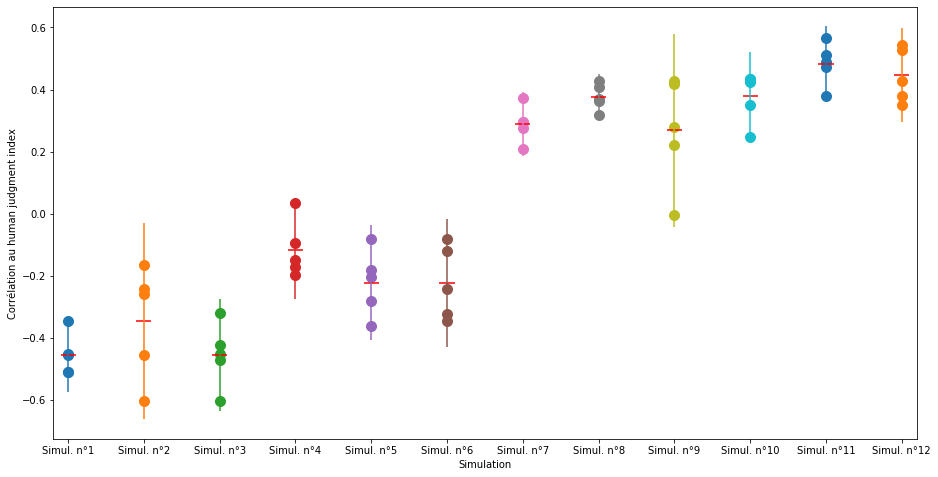

In [193]:
intervalles_confiance(simul, "cos")

-0.2846153846153846
-0.29670329670329665
-0.23406593406593407
-0.23186813186813185
-0.23956043956043954
-0.19340659340659339
-0.3747252747252747
-0.3604395604395604
-0.3747252747252748
-0.39670329670329674
-0.33076923076923076
-0.3065934065934066


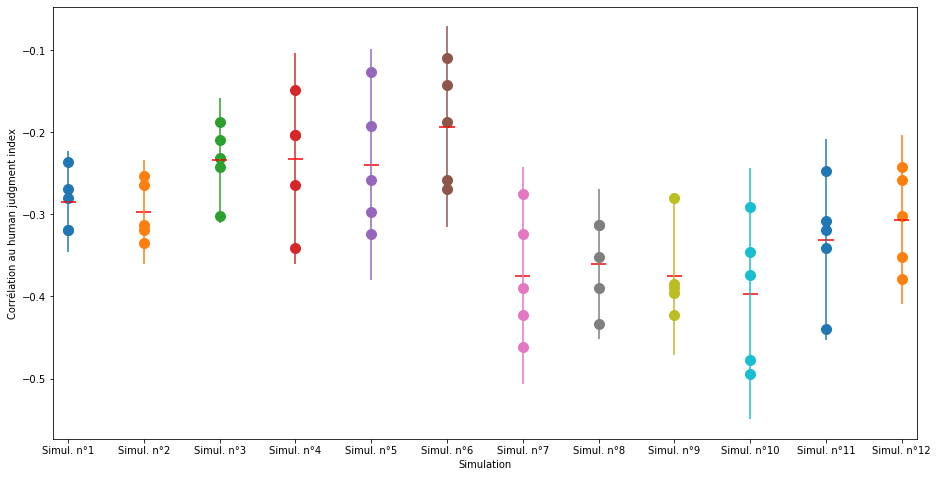

In [194]:
intervalles_confiance(simul, "eucl")

# 3. PCA

In [81]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


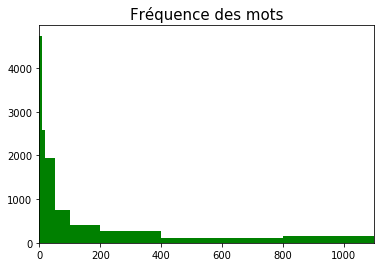

In [46]:
#def creer_liste_random(liste, statique = True, nom_couples_explicite=True):

import matplotlib.pyplot as plt
plt.hist(fdist.values(), bins=[0,10,20,50, 100, 200,400,800,max(fdist.values())],color='g') #width=100, range=(0, 50000)
plt.xlim(xmin=0, xmax = 1100)
plt.title('Fréquence des mots', fontsize=15)
plt.show()

In [47]:
np.random.seed(1)

mots0_20 = dict()
mots20_100 = dict()
mots100_1000 = dict()
mots1000_max = dict()

for (key, value) in fdist.items():
    if value <= 20 :
        mots0_20[key] = value
    if value > 20 and value <= 100 :
        mots20_100[key] = value
    if value > 100 and value <= 1000 :
        mots100_1000[key] = value        
    if value > 1000 :
        mots1000_max[key] = value


liste_0_20 = list(np.random.choice(list(mots0_20.keys()), size=100))
liste_20_100 = list(np.random.choice(list(mots20_100.keys()), size=100))
liste_100_1000 = list(np.random.choice(list(mots100_1000.keys()), size=100))
liste_1000_max = list(np.random.choice(list(mots1000_max.keys()), size=100))

liste2 = [liste_0_20, liste_20_100, liste_100_1000, liste_1000_max]

In [49]:
#liste = [["homme","femme", "enfant"],["chien","chat"],
#         ["vanille","chocolat"],
#    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
#    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

#liste = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
#    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
#    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
#    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
#    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
#    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
#    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
#    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
#    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
#    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
#]

liste1 = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

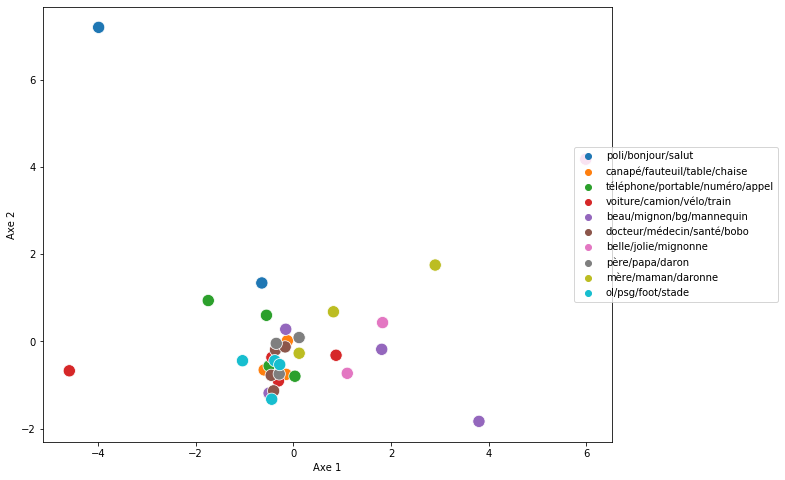

In [50]:
ACP(liste1, statique = True)

In [51]:
ACP(liste1, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [52]:
ACP(liste2, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



# 4. TSNE

In [53]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')
        

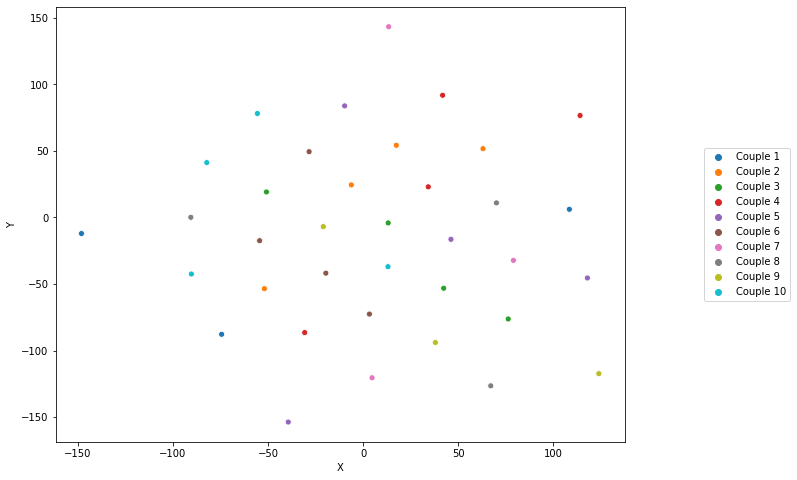

In [54]:
tsne_graph(liste1, statique = True,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?

In [55]:
tsne_graph(liste1, statique = False,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [56]:
tsne_graph(liste2, statique = False,
           nom_couples_explicite = True)#Paramètre ne marche pas : a debuger ?

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

